# Engagement prediction

### Feature set

Let's build classification model that predicts if __given user would be engaged in next 30 days__. At the first step let's build feature set for the model with following logic - for predefined set of dates (e.g. start months dates from Sep, 2018 thru Apr, 2019) let's calculate various user metrics for different events that happened before considered date and calculate whether or not user became engaged 30 days after considered date. There are several type of user features that we can calculate:
* transactional features (number of orders, recency, frequency etc. - various metrics from transactions table)
* user features (all columns from users table)
* device info (brand name from devices dataset)
* notification info (let's calculate whether or not user has received notification X days prior to considered date, let's put X to be 7 days the same as it is mentioned in Question 1)

All those metrics were extracted with SQL query, that is stored in the query.sql file. Let's load and inspect data frame with features that was extracted from DB.

In [2]:
import pandas as pd
dataset = pd.read_csv('data/dataset_for_model.csv')
dataset.describe(include='all')

,month_start,user_id,is_engaged_next_period,age,country,city,tenure,user_settings_crypto_unlocked,is_premium_plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,brand,has_received_notification,number_orders,days_since_last_transaction,active_period,frequency
count,144020,144020,144020.000000,144020,144020,144020,144020.000000,144020.000000,144020.000000,96012.000000,96012.000000,144020.000000,144020.0,144020.0,144020,144020.000000,144020.000000,72719.000000,72719.000000,72719.000000
unique,9,19430,NaN,4,41,6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
top,2019-04-01T00:00:00.000Z,user_6206,NaN,31-40,GB,London,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apple,NaN,NaN,NaN,NaN,NaN
freq,19430,9,NaN,44731,49051,13203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72288,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.296577,NaN,NaN,NaN,6.103284,0.191161,0.076302,0.946975,0.893638,17.130669,0.0,0.0,NaN,0.110873,12.721323,56.347323,132.870584,9.533174
std,NaN,NaN,0.456750,NaN,NaN,NaN,3.452443,0.393217,0.265481,0.224084,0.308302,45.919557,0.0,0.0,NaN,0.313977,27.186387,77.971587,106.188581,12.810843
min,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,0.000000,0.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,0.000000,NaN,NaN,NaN,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0,NaN,0.000000,0.000000,4.000000,34.000000,2.428571
50%,NaN,NaN,0.000000,NaN,NaN,NaN,6.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.0,0.0,NaN,0.000000,1.000000,20.000000,121.000000,5.500000
75%,NaN,NaN,1.000000,NaN,NaN,NaN,9.000000,0.000000,0.000000,1.000000,1.000000,18.000000,0.0,0.0,NaN,0.000000,13.000000,79.000000,210.000000,11.333333


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144020 entries, 0 to 144019
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   month_start                               144020 non-null  object 
 1   user_id                                   144020 non-null  object 
 2   is_engaged_next_period                    144020 non-null  int64  
 3   age                                       144020 non-null  object 
 4   country                                   144020 non-null  object 
 5   city                                      144020 non-null  object 
 6   tenure                                    144020 non-null  int64  
 7   user_settings_crypto_unlocked             144020 non-null  int64  
 8   is_premium_plan                           144020 non-null  int64  
 9   attributes_notifications_marketing_push   96012 non-null   float64
 10  attributes_notificat

### Features processing

As we can see there are some missing values in the dataset for the following variables: <br> 
- attributes_notifications_marketing_push<br>
- attributes_notifications_marketing_email<br> 
- days_since_last_transaction<br> 
- active_period<br> 
- frequency<br>

Last three variables are nulls in the case when the user didn't have any transaction history before the given date. 

Also features *age, country, city and brand* are categorical, while others are numerical.
Finally, num_referrals and num_successful_referrals are 0 for all users. Let's drop some features from dataset that won't be helpful for prediction.

In [8]:
month_index = dataset.month_start 
df = dataset[dataset.columns[~dataset.columns.isin(['month_start', 'user_id', 'country', 'city', 'num_referrals', 'num_successful_referrals' ])]]

*Some notes on dropped variables*: <br>
- month_start might be actually useful for prediction as it can have info on seasonality (but let's ignore it for simplicity) <br>
- Country and City info could be helpful as well, but since there are large number of countries/cities with only few users, so better to get rid of it <br> 

If we look at devices' brand, there are only 345 cases when brand = 'Unknown', so we might drop it as well and transform *brand* column into *is_apple*

In [9]:
df.groupby('brand').size()

brand
Android    71387
Apple      72288
Unknown      345
dtype: int64

In [10]:
df = df[df.brand != 'Unknown']
df.loc[df.brand != 'Apple', 'brand'] = 0
df.loc[df.brand == 'Apple','brand'] = 1
df = df.rename(columns = {"brand": 'is_apple'})
df.head()

,is_engaged_next_period,age,tenure,user_settings_crypto_unlocked,is_premium_plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,is_apple,has_received_notification,number_orders,days_since_last_transaction,active_period,frequency
0,0,26-30,1,0,0,1.0,1.0,15,0,0,1,28.0,1.0,1.000000
1,1,31-40,6,0,0,1.0,0.0,80,0,0,20,21.0,143.0,7.150000
2,0,26-30,3,0,0,NaN,NaN,0,0,0,7,1.0,73.0,10.428571
3,1,31-40,2,0,0,1.0,1.0,63,1,0,0,NaN,NaN,NaN
4,0,18-25,2,0,0,1.0,1.0,44,0,0,0,NaN,NaN,NaN


#### Dummy encoding of categorical variables

Let's apply dummy encoding for remaining categorical variables, e.g. age

In [11]:
categorical_to_dummy_encode = ['age']
df_no_categorical = df[df.columns[~df.columns.isin(categorical_to_dummy_encode)]]
for colname in categorical_to_dummy_encode:
    dummies = pd.get_dummies(df[colname])
    df_no_categorical = pd.concat([df_no_categorical, dummies], axis=1, sort=False)
df = df_no_categorical
df.head()

,is_engaged_next_period,tenure,user_settings_crypto_unlocked,is_premium_plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,is_apple,has_received_notification,number_orders,days_since_last_transaction,active_period,frequency,18-25,26-30,31-40,40 plus
0,0,1,0,0,1.0,1.0,15,0,0,1,28.0,1.0,1.000000,0,1,0,0
1,1,6,0,0,1.0,0.0,80,0,0,20,21.0,143.0,7.150000,0,0,1,0
2,0,3,0,0,NaN,NaN,0,0,0,7,1.0,73.0,10.428571,0,1,0,0
3,1,2,0,0,1.0,1.0,63,1,0,0,NaN,NaN,NaN,0,0,1,0
4,0,2,0,0,1.0,1.0,44,0,0,0,NaN,NaN,NaN,1,0,0,0


#### Handling NaNs

There are NaNs in the following features: <br>
- attributes_notifications_marketing_push <br>
- attributes_notifications_marketing_email <br>
- days_since_last_transaction <br> 
- active_period <br>
- frequency <br> 

The reason why there is missing data for *days_since_last_transaction, active_period, frequency* variables because users didn't make any transactions before given date.  
There are two main strategies to deal with missing values: impute missing values or drop rows with missing values.
We believe that transactional features should be good predictors for engagement in next 30 days and therefore it is not appropriate to fill missing values for those variables. Then the remaining strategy for us would be dropping rows where these variables are missing.
If we would like to that issue and build forecast for users without transactions as well, we should build separate model(which will likely have weaker prediction power). For sake of simplicity let's ignore those users.

As for missing values in case of *attributes_notifications_marketing_push, attributes_notifications_marketing_email* variables we can try to impute it with median (it only has values 1 or 0 so it doesn't make sense to impute it with mean). 
So let's handle missing data as discussed above.

In [12]:
# imputing with median
impute_when_missing = ['attributes_notifications_marketing_push', 'attributes_notifications_marketing_email']
for feature in impute_when_missing:
    filler = df[feature].median()
    df[feature] = df[feature].fillna(filler)

# dropping rows without transactional info
df = df[~df.frequency.isnull()]
#checking if dataset doesn't have anymore NaNs
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72482 entries, 0 to 144016
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   is_engaged_next_period                    72482 non-null  int64  
 1   tenure                                    72482 non-null  int64  
 2   user_settings_crypto_unlocked             72482 non-null  int64  
 3   is_premium_plan                           72482 non-null  int64  
 4   attributes_notifications_marketing_push   72482 non-null  float64
 5   attributes_notifications_marketing_email  72482 non-null  float64
 6   num_contacts                              72482 non-null  int64  
 7   is_apple                                  72482 non-null  object 
 8   has_received_notification                 72482 non-null  int64  
 9   number_orders                             72482 non-null  int64  
 10  days_since_last_transaction      

#### Checking correlations between features

We are planning to use several methods for modelling, namely random forest and logistic regression, while in case of the random forest highly correlated variables should not cause multicollinearity issues, in second case it is better to check and get rid (if any) of them. The same for data normalization - first method doesn't require normalization, while second requires. Since we would like to compare the performance of those two methods it is better to input the same data. So let's check correlation and then normalize all non binary data.

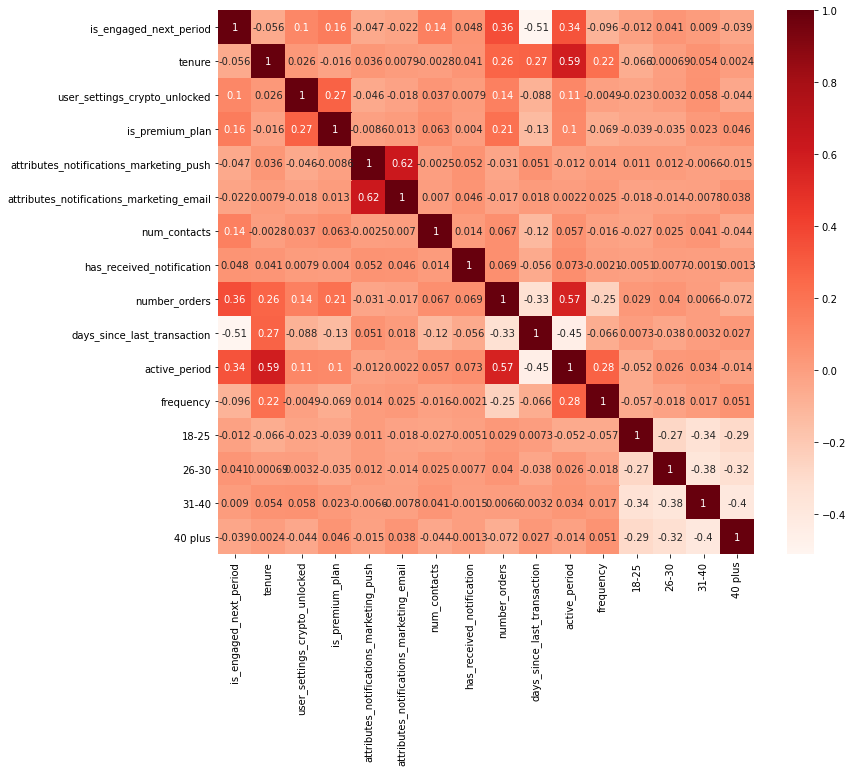

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

This diagram shows that there are some correlation between variables: <br>
- tenure, active period and number_orders <br>
- attributes_notifications_marketing_push and attributes_notifications_marketing_email <br>

Since correlation is not very strong, let's keep all the variables.

#### Normalizaition

In [14]:
# splitting dataset into binary and non binary features. Former won't require normalization
df_non_binary = df[['tenure', 'num_contacts', 'number_orders', 'days_since_last_transaction', 'active_period', 'frequency']]
df_binary = df[df.columns[~df.columns.isin(df_non_binary.columns)]]
normalized_df_non_binary=(df_non_binary-df_non_binary.mean())/df_non_binary.std()
normalized_df = pd.concat([normalized_df_non_binary, df_binary], axis=1, sort=False)

normalized_df.head()

,tenure,num_contacts,number_orders,days_since_last_transaction,active_period,frequency,is_engaged_next_period,user_settings_crypto_unlocked,is_premium_plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,is_apple,has_received_notification,18-25,26-30,31-40,40 plus
0,-2.192917,-0.007997,-0.713284,-0.364677,-1.240702,-0.666023,0,0,0,1.0,1.0,0,0,0,1,0,0
1,-0.610054,1.422878,-0.150812,-0.454362,0.097177,-0.186399,1,0,0,1.0,0.0,0,0,0,0,1,0
2,-1.559772,-0.338199,-0.535661,-0.710606,-0.562341,0.069289,0,0,0,1.0,1.0,0,0,0,1,0,0
6,-0.610054,-0.338199,-0.210019,-0.223743,-0.157208,-0.241424,1,0,1,0.0,1.0,0,0,0,0,0,1
7,0.656237,-0.030011,-0.417246,-0.505611,1.077032,1.007167,1,0,0,0.0,0.0,0,0,0,0,1,0


### Building model

We are planning to use and compare perfomance of two out of box classification algorithms without any parameters tuning: <br>
- logistic regression <br>
- random forest <br> 

To compare performance we would use ROC AUC metric calculated on 5 fold cross-validation.


In [16]:
X = normalized_df[normalized_df.columns[~normalized_df.columns.isin(['is_engaged_next_period'])]]
Y = normalized_df['is_engaged_next_period']

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42,n_estimators = 100)
clf = LogisticRegression(random_state=42, solver='lbfgs')

rf_roc_auc = cross_val_score(rf, X,Y, cv=5, scoring = 'roc_auc')
clf_roc_auc = cross_val_score(clf, X,Y, cv=5, scoring = 'roc_auc')
print(round(rf_roc_auc.mean(), 3), round(clf_roc_auc.mean(), 3))

0.865 0.858


Random forest algorithm is showing better score, so let's user it for predictions. Additionally, it is interesting to see feature importance which is output by random forest algorithm to check what are the most important factors for engagement prediction.

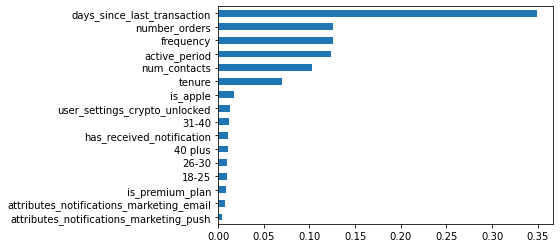

In [17]:
rf.fit(X, Y)
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importance.plot(kind='barh')

As it was expected, the most important features are transactional, particularly, days since last transaction. Non transactional feature with highest importance is number of contacts. From correlation plot above we can see that it has positive correlation with target variable, e.g. the more contacts the better chance to be engaged next period of time.